### Import the Libraries

In [38]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm

# NLP Imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, add,Concatenate,Reshape, Bidirectional

# Model creation Imports
from tensorflow.keras.models import Sequential, Model

# Computer Vision Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet201

# Model Learning & Losses imports
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Warning and Visualization Imports
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

### Load the Dataset

In [39]:
img_path ='/kaggle/input/flickr8k/Images'
data = pd.read_csv('/kaggle/input/flickr8k/captions.txt')
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


## Visualization: Image and their corresponding captions

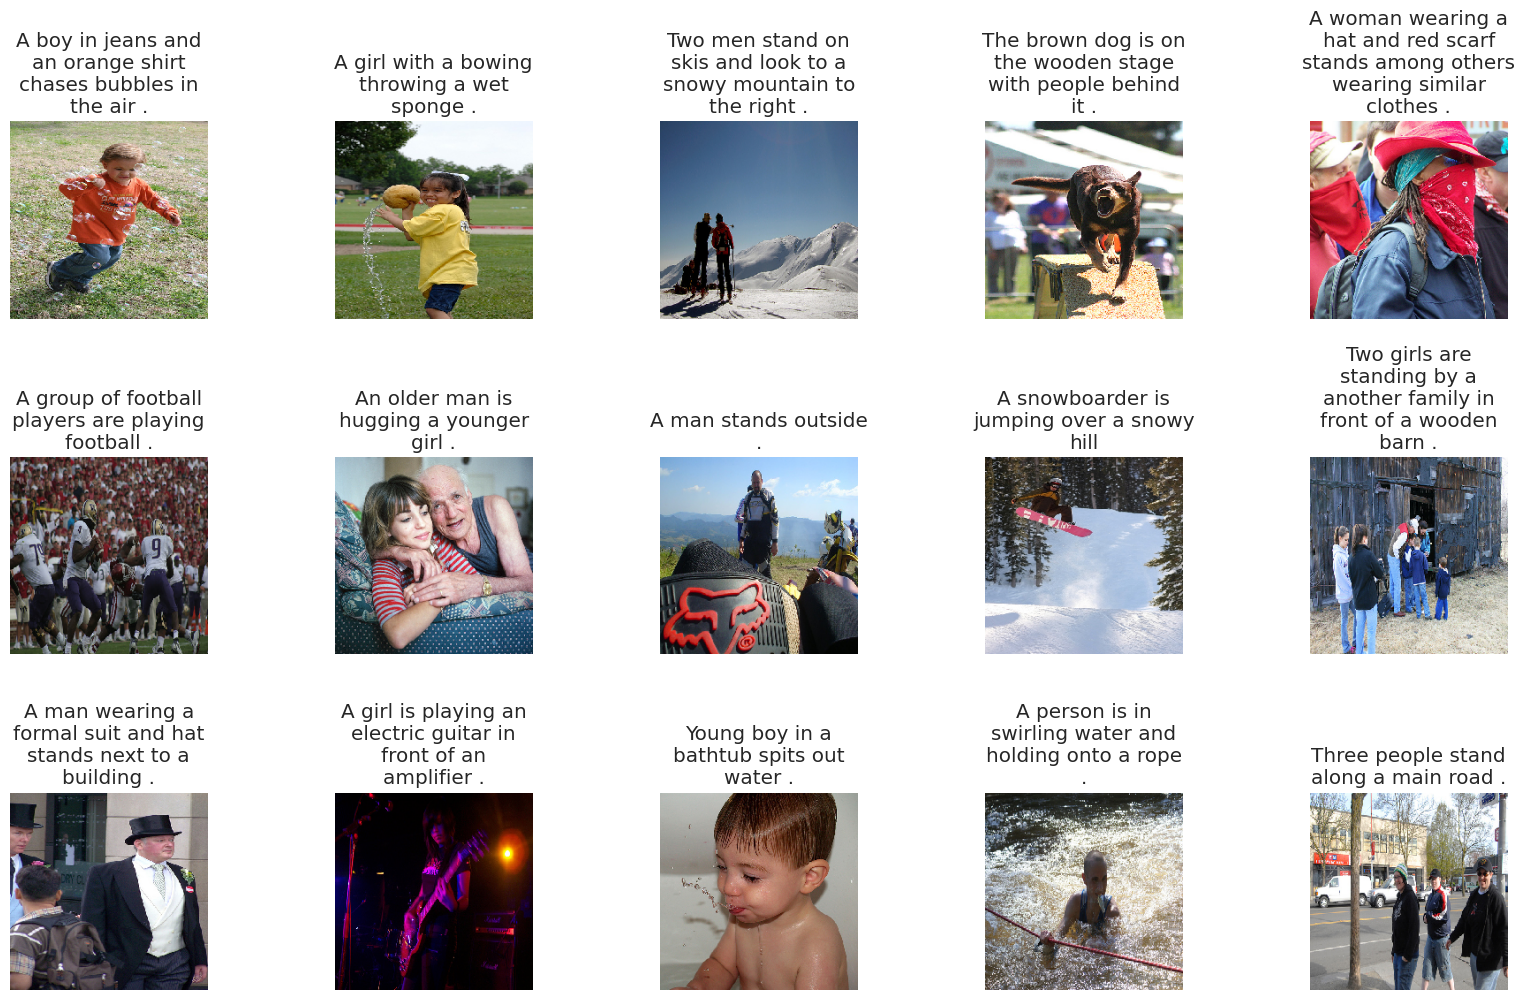

In [40]:
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    return img


def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20,20))
    n=0
    for i in range(15):
        n+=1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image=readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

display_images(data.sample(15))

### Caption text Processing

In [41]:
def text_preprocessing(data):
    data['caption']=data['caption'].apply(lambda x: x.lower())
    data['caption']=data['caption'].apply(lambda x: x.replace("[^A-Za-z]", ""))
    data['caption']=data['caption'].apply(lambda x: x.replace("\s+", ""))
    data['caption']=data['caption'].apply(lambda x: "".join([word for word in x.split() if len(word)>1]))
    data['caption']="startseq "+data['caption']+" endseq"
                                          
    return data                                      

data= text_preprocessing(data)

In [42]:
data['caption'][0]

'startseq childinpinkdressisclimbingupsetofstairsinanentryway endseq'

In [43]:
captions=data['caption'].tolist()

In [44]:
captions[:10]

['startseq childinpinkdressisclimbingupsetofstairsinanentryway endseq',
 'startseq girlgoingintowoodenbuilding endseq',
 'startseq littlegirlclimbingintowoodenplayhouse endseq',
 'startseq littlegirlclimbingthestairstoherplayhouse endseq',
 'startseq littlegirlinpinkdressgoingintowoodencabin endseq',
 'startseq blackdogandspotteddogarefighting endseq',
 'startseq blackdogandtri-coloreddogplayingwitheachotherontheroad endseq',
 'startseq blackdogandwhitedogwithbrownspotsarestaringateachotherinthestreet endseq',
 'startseq twodogsofdifferentbreedslookingateachotherontheroad endseq',
 'startseq twodogsonpavementmovingtowardeachother endseq']

### Tokenization